In [1]:
#pip install imbalanced-learn

In [2]:
#pip install xgboost

In [3]:
#pip install imbalanced-learn before running the code - used for balancing the set in the later [random forest] part of the code
# pip install xgboost before running the code - used for the xgboost model
#pip install codecs before running the code - used for file import to dataframe

In [43]:
%matplotlib inline
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error,mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import codecs

Dataframe edit for visuals

In [5]:
with codecs.open("../Project-4/Resources/DataCoSupplyChainDataset_Original.csv", 'r', encoding='ISO-8859-1') as f:
    DataCO_df = pd.read_csv(f)


DataCO_df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [6]:
#drop non-beneficial columns

co_data = DataCO_df.copy()
FeatureList = ['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Id', 'Customer Segment',
       'Customer State', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Card Id', 'Product Category Id', 'Product Name', 'Product Price',
       'shipping date (DateOrders)', 'Shipping Mode']
df_a = DataCO_df[FeatureList]
df_a.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,-247.779999,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.75,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,22.860001,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.75,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.75,1/15/2018 11:24,Standard Class


## Visuals from initial data exploration

In [7]:
#Category Name Visual
data_Category_Name=df_a.groupby(['Category Name'])['Order Id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= True)
px.bar(data_Category_Name, x='Number of Orders',y = 'Category Name',color ='Number of Orders')


In [8]:
#Type of Payment Visual
df_payment_type=df_a.groupby([ 'Type'])['Sales'].sum().reset_index(name='Sales of Orders').sort_values(by= 'Sales of Orders', ascending= False)
px.bar(df_payment_type.head(10), x='Sales of Orders',y = 'Type',color ='Sales of Orders')

In [9]:
#Customer Segments Visual
data_Customer_Segment=df_a.groupby(['Customer Segment'])['Order Id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= False)
px.pie(data_Customer_Segment, values='Number of Orders', names= 'Customer Segment' , title= 'Number of Orders of different Customer Segments', 
       width=600 , height=600 , color_discrete_sequence = px.colors.sequential.RdBu)


## Linear Regression: Sales Prediction based on Order Volume

In [10]:
#read csv file to dataframe
sales_df = pd.read_csv("../Project-4/Resources/sales_df_VL.csv")
sales_df.head(5)

,order_date_VL,sales_per_day_VL,order_volume_VL,profit_per_day_VL,month_year_VL,item_qty_per_day_VL,avg_discount_per_day_VL,avg_product_price_per_day_VL
0,2015-01-01,28958.730381,57,4361.270029,2015-01,353,0.114880,136.668859
1,2015-01-02,25948.820225,52,1162.729983,2015-01,341,0.099664,124.169533
2,2015-01-03,32859.300341,60,5366.600017,2015-01,392,0.092402,136.982406
3,2015-01-04,31869.500330,62,5630.989989,2015-01,410,0.104241,123.622673
4,2015-01-05,27533.050215,57,3088.100046,2015-01,373,0.113875,121.256816


In [11]:
X = sales_df[['order_volume_VL','item_qty_per_day_VL','avg_discount_per_day_VL','avg_product_price_per_day_VL']]
y = sales_df["sales_per_day_VL"].values.reshape(-1, 1)

In [12]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [13]:
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R-squared: 0.9452063923653357
RMSE: 712.0717319595925
MAE: 550.7522186313083


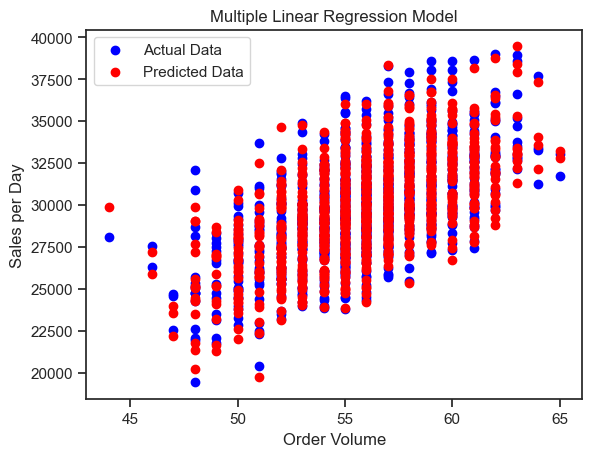

In [14]:
#plot the actual data versus the predicted data
plt.scatter(X['order_volume_VL'], y, color='blue', label='Actual Data')
plt.scatter(X['order_volume_VL'], y_pred, color='red', label='Predicted Data')
plt.xlabel('Order Volume')
plt.ylabel('Sales per Day')
plt.legend()
plt.title('Multiple Linear Regression Model')
plt.show()

## Supervised Learning: Late Delivery Risk Classification

Dataframe edit for Delivery Risk Classification

In [15]:
# Dropping irrelevant columns
cols_to_drop = [
    'Customer Email',
    'Customer Fname',
    'Customer Id',
    'Customer Lname',
    'Customer Password',
    'Order Id',
    'Order Item Cardprod Id',
    'Product Card Id',
    'Product Category Id',
    'Product Description',
    'Product Image',
    'Product Name',
    'Product Status',
    'Order Zipcode',
    'shipping date (DateOrders)', 
    'Delivery Status',
    'Days for shipping (real)'
    ]
df_c = DataCO_df.drop(cols_to_drop, axis=1)
df_c.head()

,Type,Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Segment,...,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Price,Shipping Mode
0,DEBIT,4,91.250000,314.640015,0,73,Sporting Goods,Caguas,Puerto Rico,Consumer,...,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,327.75,Standard Class
1,TRANSFER,4,-249.089996,311.359985,1,73,Sporting Goods,Caguas,Puerto Rico,Consumer,...,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,327.75,Standard Class
2,CASH,4,-247.779999,309.720001,0,73,Sporting Goods,San Jose,EE. UU.,Consumer,...,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,327.75,Standard Class
3,DEBIT,4,22.860001,304.809998,0,73,Sporting Goods,Los Angeles,EE. UU.,Home Office,...,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,327.75,Standard Class
4,PAYMENT,4,134.210007,298.250000,0,73,Sporting Goods,Caguas,Puerto Rico,Corporate,...,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,327.75,Standard Class


In [16]:
# Handle missing values
df_c['Customer Zipcode'].fillna(0, inplace=True)  # Replace missing zipcodes with 0

In [17]:
# Encode categorical variables
label_encoders = {}
categorical_cols = df_c.select_dtypes(include=['object']).columns
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df_c[col] = label_encoders[col].fit_transform(df_c[col])

In [18]:
# Define features (X) and target (y)
X = df_c.drop('Late_delivery_risk', axis=1)
y = df_c['Late_delivery_risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [21]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Key: (0) = Not Late, (1) = Late")
print(f"-----------------------------")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Key: (0) = Not Late, (1) = Late
-----------------------------
Accuracy: 0.8556392643474408
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     16307
           1       0.93      0.80      0.86     19797

    accuracy                           0.86     36104
   macro avg       0.86      0.86      0.86     36104
weighted avg       0.87      0.86      0.86     36104



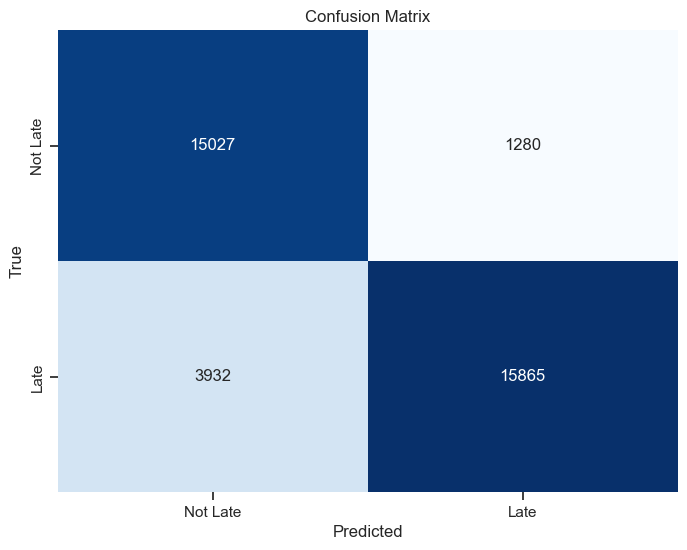

In [22]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Late', 'Late'], yticklabels=['Not Late', 'Late'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

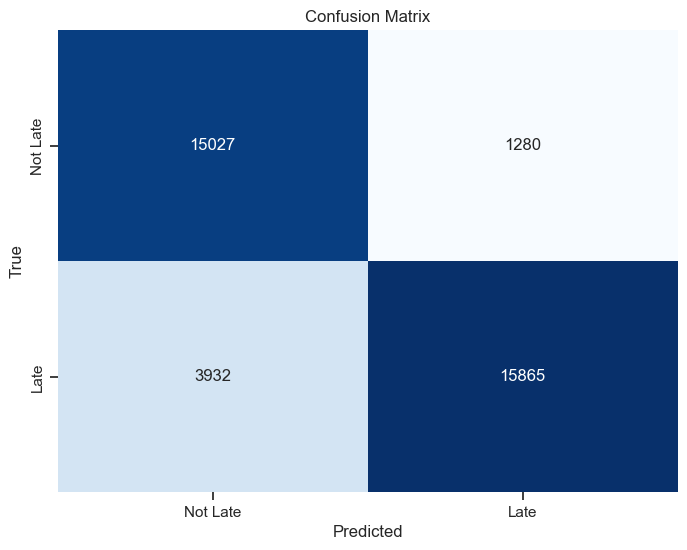

In [23]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Late', 'Late'], yticklabels=['Not Late', 'Late'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression: Fraudulent Orders Prediction

Unique order dataframe preparation

In [66]:
with codecs.open("../Project-4/Resources/DataCoSupplyChainDataset_Original.csv", 'r', encoding='ISO-8859-1') as f:
    sales_df = pd.read_csv(f)

sales_df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [67]:
sales_df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [68]:
#remove rows with "Delivery Status"="Shipping canceled"
sales_df = sales_df[sales_df["Order Status"] != "CANCELED"]

In [69]:
#remove columns 'Days for shipping (real)', 'Late_delivery_risk'
sales_df = sales_df.drop(columns=['Days for shipping (real)', 'Late_delivery_risk'])

In [70]:
# create a new dataframe orders_df listing all unique "Order ID" as index with min "Type", "Days for shipment (scheduled)"
orders_df = sales_df.groupby("Order Id").agg({"Type": "min", "Days for shipment (scheduled)": "min"})
#add columns to orders_df from sales_df with 'Customer Segment', 'Department Id', 'Order Country'
orders_df = orders_df.join(sales_df.groupby("Order Id").agg({"Customer Segment": "min","Market":"min", "Order Country": "min", "Order State":"min",
                                                             "Shipping Mode":"min","Order Region":"min",
                                                             "Order Status":"min"}))
#add columns to orders_df from sales_df with sum of "Order Item Product Price", "Order Item Discount", 'Order Item Quantity',"Order Item Total"
orders_df = orders_df.join(sales_df.groupby("Order Id").agg({"Order Item Product Price": "sum", "Order Item Discount": "sum", "Order Item Quantity": "sum", "Order Item Total": "sum"}))
# add column with number of unique "Product Card Id" per "Order Id"
orders_df["Number of Products"] = sales_df.groupby("Order Id")["Product Card Id"].nunique()
#add column with number of unique "Category Name" per "Order Id"
orders_df["Number of Categories"] = sales_df.groupby("Order Id")["Category Name"].nunique()
#add column with number of unique "Department Name" per "Order Id"
orders_df["Number of Departments"] = sales_df.groupby("Order Id")["Department Name"].nunique()
orders_df.tail()

,Type,Days for shipment (scheduled),Customer Segment,Market,Order Country,Order State,Shipping Mode,Order Region,Order Status,Order Item Product Price,Order Item Discount,Order Item Quantity,Order Item Total,Number of Products,Number of Categories,Number of Departments
Order Id,,,,,,,,,,,,,,,,
77200,TRANSFER,4,Consumer,Pacific Asia,Indonesia,Java Occidental,Standard Class,Southeast Asia,PROCESSING,215.820007,53.959999,1,161.869995,1,1,1
77201,DEBIT,4,Consumer,Pacific Asia,Indonesia,Java Occidental,Standard Class,Southeast Asia,COMPLETE,215.820007,43.160000,1,172.660004,1,1,1
77202,DEBIT,4,Consumer,Pacific Asia,Indonesia,Java Occidental,Standard Class,Southeast Asia,COMPLETE,327.750000,13.110000,1,314.640015,1,1,1
77203,PAYMENT,4,Corporate,Pacific Asia,Indonesia,Java Occidental,Standard Class,Southeast Asia,PENDING_PAYMENT,11.540000,0.630000,1,10.910000,1,1,1
77204,CASH,0,Corporate,Pacific Asia,Australia,Queensland,Same Day,Oceania,CLOSED,39.750000,4.770000,1,34.980000,1,1,1


In [71]:
orders_df.columns

Index(['Type', 'Days for shipment (scheduled)', 'Customer Segment', 'Market',
       'Order Country', 'Order State', 'Shipping Mode', 'Order Region',
       'Order Status', 'Order Item Product Price', 'Order Item Discount',
       'Order Item Quantity', 'Order Item Total', 'Number of Products',
       'Number of Categories', 'Number of Departments'],
      dtype='object')

In [72]:
#change column name "Order Item Total" to "order_total", change column "Order Item Product Price" to "order_original_price", "Order Item Discount" to "order_discount", "Order Item Quantity" to "no_of_items"
orders_df = orders_df.rename(columns={"Order Item Total": "order_total", "Order Item Product Price": "order_original_price", 
                                      "Order Item Discount": "order_discount", "Order Item Quantity": "no_of_items",
                                      "Number of Products": "no_of_unique_items", "Number of Categories": "no_of_unique_categories","Number of Departments": "no_of_unique_departments"})

In [73]:
#add column "fraud" to orders_df - mark status "SUSPECTED_FRAUD" as 1, others as 0
orders_df["fraud"] = np.where(orders_df["Order Status"] == "SUSPECTED_FRAUD", 1, 0)
#drop column "Order Status" column from orders_df
orders_df = orders_df.drop(columns=["Order Status"])
# make "fraud" an integer
orders_df["fraud"] = orders_df["fraud"].astype(int)

In [74]:
#show data type for each column
orders_df.dtypes

Type                              object
Days for shipment (scheduled)      int64
Customer Segment                  object
Market                            object
Order Country                     object
Order State                       object
Shipping Mode                     object
Order Region                      object
order_original_price             float64
order_discount                   float64
no_of_items                        int64
order_total                      float64
no_of_unique_items                 int64
no_of_unique_categories            int64
no_of_unique_departments           int64
fraud                              int64
dtype: object

In [75]:
#read csv file into dataframe orders_df from Resources folder
file_path = Path("Resources/orders_df.csv")
orders_df = pd.read_csv(file_path)

In [76]:
#dummy code categorical columns
orders_df = pd.get_dummies(orders_df, columns=["Type", "Customer Segment", "Order Country", "Order State", "Shipping Mode", "Market", "Order Region"])
orders_df.head()

,Order Id,Days for shipment (scheduled),Late_delivery_risk,Order Status,order_original_price,order_discount,no_of_items,order_total,no_of_unique_items,no_of_unique_categories,...,Order Region_South Asia,Order Region_South of USA,Order Region_Southeast Asia,Order Region_Southern Africa,Order Region_Southern Europe,Order Region_US Center,Order Region_West Africa,Order Region_West Asia,Order Region_West of USA,Order Region_Western Europe
0,1,4,0,CLOSED,299.980011,60.000000,1,239.979996,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,4,0,PENDING_PAYMENT,379.980011,50.600000,7,529.380005,3,3,...,0,0,0,0,0,0,0,0,0,0
2,4,4,1,CLOSED,184.960001,78.980000,14,620.870014,4,4,...,0,0,0,0,0,0,0,0,0,0
3,5,4,1,COMPLETE,839.920029,142.789999,10,987.070007,4,4,...,0,0,0,0,0,0,0,0,0,0
4,7,2,1,COMPLETE,515.960016,54.400000,7,525.520004,3,3,...,0,0,0,0,0,0,0,0,0,0


In [77]:
#show row count
orders_df.count()

Order Id                         62897
Days for shipment (scheduled)    62897
Late_delivery_risk               62897
Order Status                     62897
order_original_price             62897
                                 ...  
Order Region_US Center           62897
Order Region_West Africa         62897
Order Region_West Asia           62897
Order Region_West of USA         62897
Order Region_Western Europe      62897
Length: 1297, dtype: int64

In [81]:
# Review the y variable Series
print(f"Labels: {y[:10]}")

Labels: 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: fraud, dtype: int64


In [82]:
# Review the X variable DataFrame
print(f"Data: {X[:10]}")

Data:    Order Id  Days for shipment (scheduled)  Late_delivery_risk  \
0         1                              4                   0   
1         2                              4                   0   
2         4                              4                   1   
3         5                              4                   1   
4         7                              2                   1   
5         8                              4                   0   
6         9                              4                   1   
7        10                              4                   1   
8        11                              4                   0   
9        12                              4                   0   

   order_original_price  order_discount  no_of_items  order_total  \
0            299.980011       60.000000            1   239.979996   
1            379.980011       50.600000            7   529.380005   
2            184.960001       78.980000           14   620.8

In [83]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
X_train.shape


(47172, 1296)

In [84]:
X_test.shape

(15725, 1296)

In [85]:
#concatenate our training data back together
train_data = pd.concat([X_train, y_train], axis=1)

In [86]:
#Create a logistic regression model
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model with class weight to handle imbalance in the dataset
classifier = LogisticRegression(max_iter=10000)


# Fit the model using scaled training data
classifier.fit(X_train, y_train)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
# Instantiate the calibrated classifier with sigmoid calibration
calibrated_clf = CalibratedClassifierCV(classifier, method='sigmoid', cv='prefit')

# Fit the calibrated classifier using the validation data (you might need to split your data again)
calibrated_clf.fit(X_train, y_train)

In [ ]:
# Get calibrated probabilities
calibrated_probs = calibrated_clf.predict_proba(X_test)

# Predict labels (if needed)
calibrated_preds = calibrated_clf.predict(X_test)

In [ ]:
print("Accuracy: ", accuracy_score(y_test, calibrated_preds))
print("Log loss: ", log_loss(y_test, calibrated_probs))

In [ ]:
# Make a prediction using the testing data with the calibrated classifier
calibrated_predictions = calibrated_clf.predict(X_test)

pd.DataFrame({"Prediction": calibrated_predictions, "Actual": y_test})

In [ ]:
# Generate a confusion matrix for the model
confusion_matrix(y_test, calibrated_predictions)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, calibrated_predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, calibrated_predictions)

# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, calibrated_predictions))

In [ ]:
# Define features set 
X = orders_df.copy()
X.drop('fraud', axis=1, inplace=True)
X.head()

In [ ]:
# Define target vector
y = orders_df["fraud"].values.reshape(-1, 1)
y[:5]


In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [ ]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [ ]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [ ]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)


In [ ]:
# Fit the model and use .ravel()on the "y_train" data. 
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
# Get the feature importance array
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted

Despite high accuracy, the recall for fraud cases is ridiculously low - A recall of 0.01 for fraud means the model is missing out on 99% of actual fraud cases, which is a significant risk in a real-world scenario. Assuming that data imbalance is the most likely issue, adding a resampling strategy to improve the recall

In [ ]:
# Rebalance the dataset
# Use SMOTE to oversample the minority class and RandomUnderSampler to undersample the majority class
resampling = Pipeline([('SMOTE', SMOTE()), ('RandomUnderSampler', RandomUnderSampler())])
X_train_balanced, y_train_balanced = resampling.fit_resample(X_train_scaled, y_train)

In [ ]:
# Create the random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_balanced, y_train_ba

In [ ]:
# Predict
predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Evaluations
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
# Use class_weight='balanced' for cost-sensitive training
rf_model = RandomForestClassifier(n_estimators=500, random_state=78, class_weight='balanced')
rf_model = rf_model.fit(X_train_balanced, y_train_balanced)


In [ ]:
# Predict probabilities
probabilities = rf_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Adjust the decision threshold to increase recall
threshold = 0.3
predictions = np.where(probabilities > threshold, 1, 0)


In [ ]:
# Evaluations
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)
acc_score = accuracy_score(y_test, predictions)

# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Increased a recall at cost of accuracy - dismall results - attempting to improve the model with XBoost to further improve fraud detection recall

In [ ]:
# Convert the dataset into an optimized data structure that XGBoost supports
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)


In [ ]:
scale_pos_weight_val = float((y_train == 0).sum() / (y_train == 1

In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'scale_pos_weight': scale_pos_weight_val,  # corrected this line
    'eta': 0.1
}

In [ ]:
# Train the model
num_rounds = 300
bst = xgb.train(params, dtrain, num_rounds)

# Predict probabilities
probabilities = bst.predict(dtest)
predictions = [1 if prob > 0.5 else 0 for prob in probabilities]

# Evaluation
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report

Class 0 (Legitimate Transactions):

Precision: 1.00 (When the model predicted a transaction was legitimate, it was correct 100% of the time.) Recall: 0.80 (The model correctly identified 80% of all legitimate transactions.) F1-Score: 0.89 (The harmonic mean of precision and recall, giving a balanced measure for this class.) Class 1 (Fraudulent Transactions):

Precision: 0.08 (When the model predicted a transaction was fraudulent, it was correct only 8% of the time.) Recall: 0.84 (The model correctly identified 84% of all fraudulent transactions, which is a good recall rate for fraud detection. However, this came at the cost of having many false positives.) F1-Score: 0.15 (Given the low precision and high recall, the F1-score for this class is low, indicating a potential area of improvement.)

Interpretation: The model seems to be taking a conservative approach to fraud detection. While it has done a commendable job in identifying 84% of the fraudulent transactions (recall for Class 1), this high recall rate for fraudulent transactions has come at the expense of a large number of false positives (3,146 legitimate transactions incorrectly flagged as fraudulent). This is reflected in the very low precision (0.08) for Class 1.

Such a model could be problematic in real-world scenarios, especially if there are high costs or inconveniences associated with falsely flagging a transaction as fraudulent.